In [1]:
# !pip install tensorflow-gpu
# import tensorflow as tf
# tf.test.gpu_device_name()

!apt install graphviz
!pip install pydot pydot-ng
!python -c "import pydot"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from IPython.display import Image

%matplotlib inline
pd.set_option('display.max_colwidth',300)
plt.rcParams["figure.figsize"][0]=12

from sklearn.metrics import accuracy_score,f1_score

# # FOR BERT EMBEDDINGS
!pip install bert-for-tf2
!pip install sentencepiece
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import os

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
     |████████████████████████████████| 40kB 1.9MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=5d461797b1d8066ed15b277e93c3adc20ab40250f01011e544b3392d58ef6b1e
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=4e1a2fa77d507f46388ee0cc013d5a64b30b8693b4c4e01d41777881c683191c
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-n

In [2]:
import pickle
train_data = pickle.load(open('/content/drive/My Drive/tempData/train_clean.data','rb')) 
valid_data = pickle.load(open('/content/drive/My Drive/tempData/valid_clean.data','rb'))
test_data = pickle.load(open('/content/drive/My Drive/tempData/test_clean.data','rb')) 

# Sequences are sent as int32 in Input layer!
# of np array and of float 32 type!
y_train=np.asarray(train_data['label']).astype(np.float32)
y_valid=np.asarray(valid_data['label']).astype(np.float32)
y_test=np.asarray(test_data['label']).astype(np.float32)

print(train_data.shape,test_data.shape,valid_data.shape)
print(train_data['label'].value_counts(normalize = True))

(8500, 4) (592, 4) (833, 4)
0    0.754706
1    0.245294
Name: label, dtype: float64


In [3]:
# Using BERT as a Layer
# if not set pooling strategy to noe then we get either reduced mean, dot prod.. res as BATCHSZ*786 
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip # BERT BASE MODEL
!unzip uncased_L-12_H-768_A-12.zip
model_dir = "uncased_L-12_H-768_A-12"
bert_model_file = os.path.join(model_dir, "bert_model.ckpt")
bert_config_file = os.path.join(model_dir, "bert_config.json")
tokenizer = FullTokenizer(vocab_file=os.path.join(model_dir, "vocab.txt"))

--2020-07-16 15:11:10--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 74.125.126.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   153MB/s    in 2.5s    

2020-07-16 15:11:13 (153 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [4]:
max_word_id = 0
at =''

def generateSequence(sentences,max_seq_len):
  token_id_sequences=[]
  token_list=[]
  max_word_id=0
  at=''
  for sentence in sentences:
      tokens = tokenizer.tokenize(sentence)
      token_list.append(tokens)
      tokens = ["[CLS]"] + tokens + ["[SEP]"] # TO HELP BERT CONSIDER IT AS A SINGLE SENTENCE
      token_indexes = tokenizer.convert_tokens_to_ids(tokens)
      max_seq_len = max(max_seq_len, len(token_indexes))
      for i,id in enumerate(token_indexes):
        if max_word_id<id:
          max_word_id=id
          at=tokens[i]
      token_id_sequences.append(token_indexes)
  # print(token_list)
  return np.array(token_id_sequences),max_seq_len,max_word_id,at;
  
max_seq_len=0
train_sequences,max_seq_len,max_word_id,at = generateSequence(train_data['cleaned'],max_seq_len)
test_sequences,max_seq_len,max_word_id,at = generateSequence(test_data['cleaned'],max_seq_len)
valid_sequences,max_seq_len,max_word_id,at = generateSequence(valid_data['cleaned'],max_seq_len)

print(max_seq_len)
print(max_word_id)
print(at)

134
29486
persist


In [5]:
# PAD SEQUENCES
max_seq_len =  60
# increasing mxlen does not gurantees higher acc!

def pad(token_id_sequences):
  final_sequences = []
  for input_ids in token_id_sequences:
    input_ids = input_ids[:min(len(input_ids), max_seq_len - 2)]
    input_ids = input_ids + [0] * (max_seq_len - len(input_ids))
    final_sequences.append(np.array(input_ids))
  return np.array(final_sequences)

x_train_sequences = pad(train_sequences)
x_valid_sequences = pad(valid_sequences)
x_test_sequences =  pad(test_sequences) 

max_word_id = 0
for seq in x_train_sequences:
  for x in seq:
    max_word_id=max(max_word_id,x)

print(x_train_sequences.shape,x_test_sequences.shape,x_valid_sequences.shape)
print(max_word_id)

(8500, 60) (592, 60) (833, 60)
29525


In [6]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter

smt = SMOTE(k_neighbors=1,random_state=2,sampling_strategy='minority')
x_train_sequence_bal,y_train_bal = smt.fit_resample(x_train_sequences,y_train)

print(Counter(y_train),Counter(y_train_bal))
print(x_train_sequence_bal.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0.0: 6415, 1.0: 2085}) Counter({1.0: 6415, 0.0: 6415})
(12830, 60)


In [7]:
max_word_id = 0
for seq in x_train_sequence_bal:
  for x in seq:
    max_word_id=max(max_word_id,x)
print(max_word_id)

29525


In [8]:
ids = [9999,10000,10001,10002,10003,10004,10005,10006,10007,10008,10009]
for i in ids:
  print(y_train_bal[i],' '.join(tokenizer.convert_ids_to_tokens(x_train_sequence_bal[i])))

1.0 [CLS] ##ter funds editorial the glass covered human under speed just [unused84] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
1.0 [CLS] there any production never they national 110 electric submarine famous back ##e into known even condemned ##se dual queen avenue final volume seven ##away slowly mysterious building special ##d corruption working º h ÷ ¹ غ where b treaty being [unused51] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
1.0 [CLS] through unanimous coast 2008 waters based gear after ##ul cabinet [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [9]:
# shuffle well
import random

ids = [ i for i in range(len(x_train_sequence_bal))]
random.shuffle(ids)

x_temp=[]
y_temp=[]

for i in ids:
  x_temp.append(x_train_sequence_bal[i])
  y_temp.append(y_train_bal[i])

del x_train_sequences
del x_train_sequence_bal
del y_train_bal
del ids

x_train = np.array(x_temp)
y_train = np.array(y_temp)

del x_temp
del y_temp

x_train.shape,y_train.shape

((12830, 60), (12830,))

Done loading 196 BERT weights from: uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcb6f8730b8> (prefix:bert_3). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 60)]         0                                            
___________________________________________________

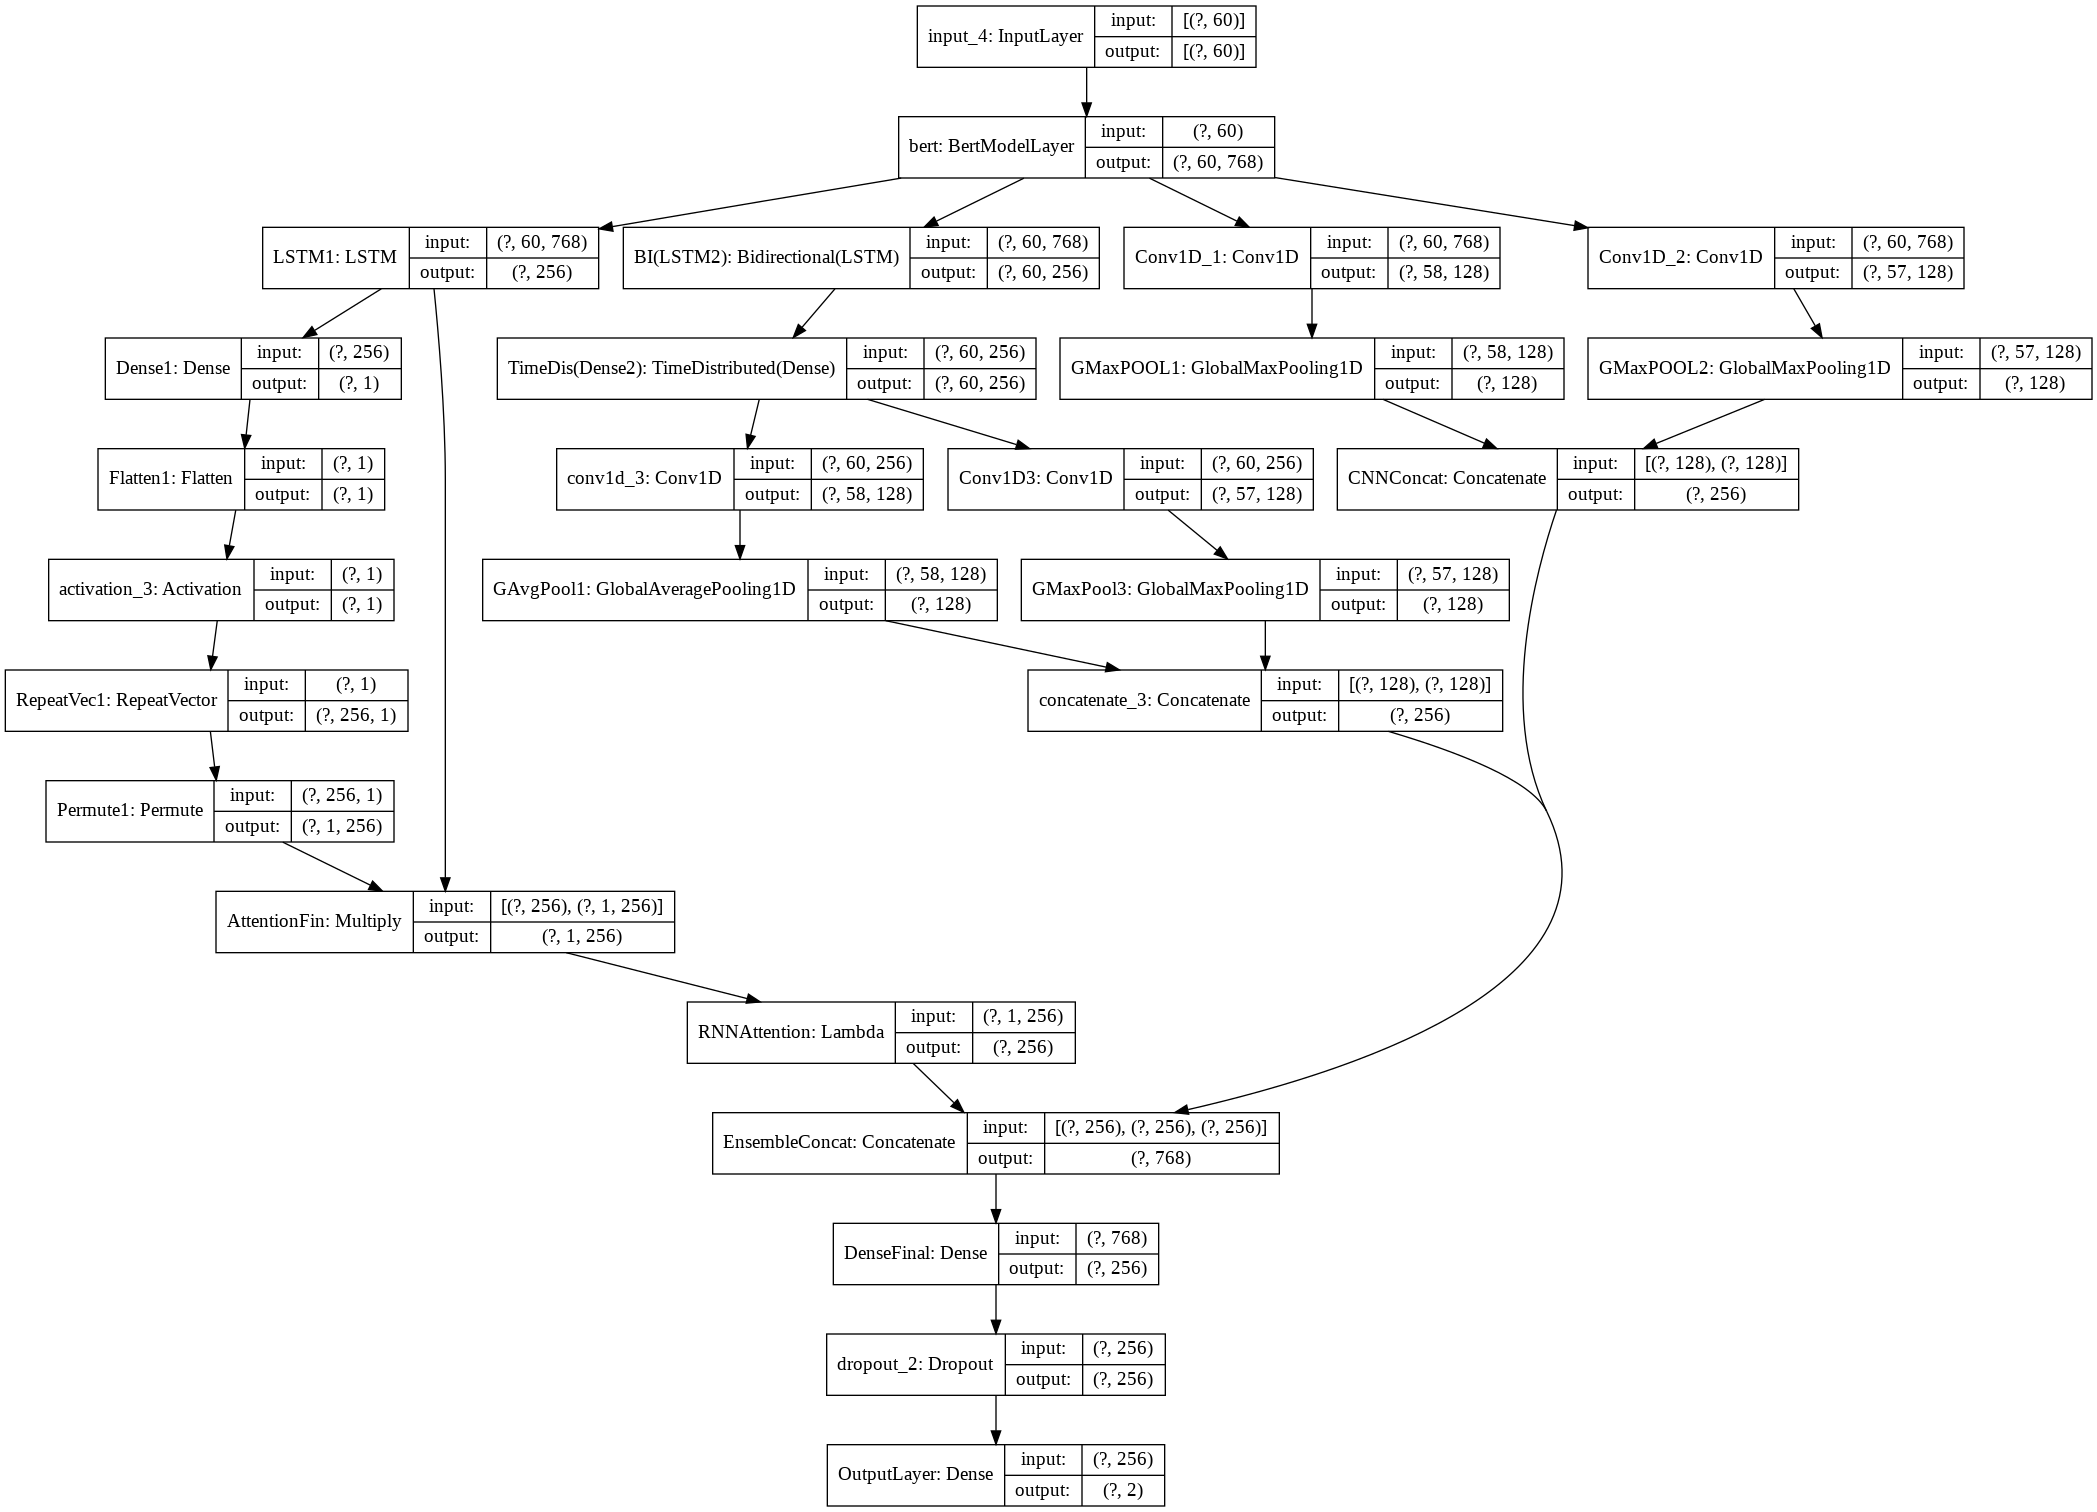

In [20]:
##################################################################################################
####### ENSEMBLE CLASSIFIER  => CNN + ATTENTION MODEL + BILSTM BASED TEXT RCNN ######### dropout and less epochs
##################################################################################################

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D,concatenate
from tensorflow.keras.layers import LSTM,Flatten,RepeatVector,Permute,Activation,Multiply,Lambda
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPool1D,Bidirectional,TimeDistributed
from tensorflow.keras.backend import sum as Ksum
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import tensorflow

UNITS = 256
UNITS_HF = 128

with tensorflow.io.gfile.GFile(bert_config_file, "r") as reader:                # LOAD BERT CONFIGURATION...............
    bc = StockBertConfig.from_json_string(reader.read())
    bert_params = map_stock_config_to_params(bc)
    bert_params.adapter_size = None
    bert = BertModelLayer.from_params(bert_params, name="bert")

input_layer= Input(shape=(max_seq_len,), dtype='int32')                         # THE INPUT LAYER 
bert_layer =    bert(input_layer)                                               # THE BERT EMBEDDINGS 

# PART 1 - CNN CLASSIFIER 
conv1 = Conv1D(UNITS_HF, 3, activation='relu',name="Conv1D_1")(bert_layer)      
conv1 = GlobalMaxPooling1D(name="GMaxPOOL1")(conv1)
conv2 = Conv1D(UNITS_HF, 4, activation='relu',name="Conv1D_2")(bert_layer)        
conv2 = GlobalMaxPooling1D(name="GMaxPOOL2")(conv2)
cnn = concatenate([conv1,conv2],name="CNNConcat") 

# PART 2 - LSTM ATTENTION CLASSIFIER
lstm_layer = LSTM(UNITS,name="LSTM1")(bert_layer)                               
attention = Dense(1, activation='tanh',name="Dense1")(lstm_layer)
attention = Flatten(name="Flatten1")(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(UNITS,name="RepeatVec1")(attention)
attention = Permute([2, 1],name="Permute1")(attention)
sent_representation = Multiply(name="AttentionFin")([lstm_layer, attention])
rnn_attention = Lambda(lambda xin: Ksum(xin, axis=-2), output_shape=(UNITS,),name="RNNAttention")(sent_representation)

# PART 3 - BILSTM BASED TEXT RCNN CLASSIFIER
bilstm_layer = Bidirectional(LSTM(128, activation="relu",return_sequences=True,name='LSTM2'),name='BI')(bert_layer)
bilstm_layer = TimeDistributed(Dense(UNITS, activation='relu',name='Dense2'),name='TimeDis')(bilstm_layer)
conv_layer_1 = Conv1D(UNITS_HF, 3, activation='relu')(bilstm_layer)        
avg_pool_layer = GlobalAveragePooling1D(name='GAvgPool1')(conv_layer_1)
conv_layer_2 = Conv1D(UNITS_HF, 4, activation='relu',name='Conv1D3')(bilstm_layer)        
max_pool_layer = GlobalMaxPooling1D(name='GMaxPool3')(conv_layer_2)
rcnn = concatenate([avg_pool_layer,max_pool_layer]) 

# ENSEMBLE CLASSIFIER
combined_layer = concatenate([cnn,rnn_attention,rcnn],name='EnsembleConcat')
dense_final = Dense(UNITS,activation="tanh",name = 'DenseFinal')(combined_layer)
# dense_final = Dense(UNITS_HF,activation="tanh",name = 'DenseFinal')(dense_layer)
dropout_layer =  Dropout(0.4)(dense_final)
output_layer = Dense(2, activation='softmax',name='OutputLayer')(dropout_layer)

# the model works well with the softmax layer output and so multilabel
# it does not trains of simple 1 dense output class

# SUMMARY 
ensemble_model = Model(input_layer,output_layer)
load_stock_weights(bert, bert_model_file)                                       # LOADING BERT WEIGHTS TO THE MODEL

ensemble_model.summary()
ensemble_model.compile(
  optimizer=Adam(1e-5),
  loss=SparseCategoricalCrossentropy(from_logits=True),
  metrics=[SparseCategoricalAccuracy(name="acc")]
)

# DISPLAY
plot_model(ensemble_model, show_shapes=True, show_layer_names=True, to_file='ensemble_model.png')
Image(retina=True, filename='ensemble_model.png')

In [15]:
EPOCHS = 5
BATCH_SIZE = 100
history = ensemble_model.fit(
    x_train,y_train,
    epochs=EPOCHS,     
    validation_data=(x_valid_sequences, y_valid), 
    batch_size=BATCH_SIZE,
    shuffle=True
)

Epoch 1/5
129/129 [==============================] - 361s 3s/step - loss: 0.5197 - acc: 0.7804 - val_loss: 0.4563 - val_acc: 0.8463
Epoch 2/5
129/129 [==============================] - 358s 3s/step - loss: 0.4168 - acc: 0.8934 - val_loss: 0.3921 - val_acc: 0.9172
Epoch 3/5
129/129 [==============================] - 359s 3s/step - loss: 0.3973 - acc: 0.9139 - val_loss: 0.3806 - val_acc: 0.9292
Epoch 4/5
129/129 [==============================] - 358s 3s/step - loss: 0.3848 - acc: 0.9271 - val_loss: 0.4019 - val_acc: 0.9064
Epoch 5/5
129/129 [==============================] - 358s 3s/step - loss: 0.3775 - acc: 0.9348 - val_loss: 0.3966 - val_acc: 0.9160


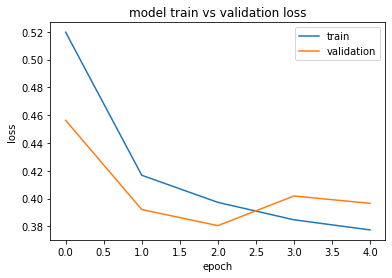

F1 Score: 78.24%
Accuracy: 79.90%


In [16]:
# TRAINING VS VALIDATION LOSS GRAPH
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

predict=ensemble_model.predict(x_test_sequences).argmax(axis=-1)
predict=[int(x+0.5) for x in predict]
accuracy = accuracy_score(y_test, predict)
f1=f1_score(y_test,predict)
print("F1 Score: %.2f%%" % (f1* 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))